# Sentiment Analysis of Reddit Posts on Stress and Anxiety Using NLP

### Importing Libraries

In [87]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import nltk
from nltk.corpus import stopwords

### Load Dataset

In [90]:
df=pd.read_csv("stressed_anx_data.csv")
df.head()

,Text,is_stressed/anxious
0,advice please hey everyone please help me im ...,1
1,does anyone get anxious about something and th...,1
2,ocd is overwhelming me ocd is overwhelming me ...,1
3,i feel so drained and exhausted i am so tired ...,1
4,any advice is appreciated hey everyone \n\nas ...,1


### Data Exploration

In [93]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Text                 3766 non-null   object
 1   is_stressed/anxious  3999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


Text                   233
is_stressed/anxious      0
dtype: int64

In [95]:
# drop null 
df = df.dropna(subset=['Text']).copy()
# reset index
df.reset_index(drop=True, inplace=True)

print("Nulls in Text after cleaning:", df['Text'].isnull().sum())

Nulls in Text after cleaning: 0


In [97]:
print("Duplicate posts:", df.duplicated(subset='Text').sum())

Duplicate posts: 52


In [99]:
df = df.drop_duplicates(subset='Text').copy()

### Light Text Cleaning

In [102]:
import re
import string

def light_clean(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '',text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

In [104]:
df['clean_text'] = df['Text'].apply(light_clean)
df[['Text', 'clean_text']].head()

,Text,clean_text
0,advice please hey everyone please help me im ...,advice please hey everyone please help me im s...
1,does anyone get anxious about something and th...,does anyone get anxious about something and th...
2,ocd is overwhelming me ocd is overwhelming me ...,ocd is overwhelming me ocd is overwhelming me ...
3,i feel so drained and exhausted i am so tired ...,i feel so drained and exhausted i am so tired ...
4,any advice is appreciated hey everyone \n\nas ...,any advice is appreciated hey everyone as you ...


In [105]:
print("Before cleaning:\n", df['Text'].iloc[0])
print("\nAfter cleaning:\n", df['clean_text'].iloc[0])

Before cleaning:
 advice please  hey everyone please help me im so convinced i have a brain tumor okay so a week ago i noticed this head pressure mainly when i get up bend down its like a squeezing for a few secondsand then i get headaches on my right side does that mean that mean theres a tumor there  if it was big enough to be causing headaches on one side wouldnt there be more symptoms the headache is mostly when i get up to do things and head just feels weird when i stand up like weird lightheaded fuzzy pressure  and idk it feels tight by my nose please reassure me this isnt a brain tumor im making a appointment tomorrow and if its to far im just gonna go to the er but im terrified to sleep because im like what if i die in my sleep how would i know if its a brain tumor  im only 21 i have bad anxiety this is so scary 

After cleaning:
 advice please hey everyone please help me im so convinced i have a brain tumor okay so a week ago i noticed this head pressure mainly when i get up b

### TF IDF Vectorization

In [109]:
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['is_stressed/anxious']
print("TF-IDF Matrix Shape:", X.shape)  # Rows = posts, Columns = top words/phrases
print("Target Shape:", y.shape)

TF-IDF Matrix Shape: (3714, 3000)
Target Shape: (3714,)


In [110]:
feature_names = tfidf.get_feature_names_out()
print("Top 20 words/phrases in TF-IDF vocabulary:\n", feature_names[:20])

Top 20 words/phrases in TF-IDF vocabulary:
 ['able' 'able to' 'about' 'about how' 'about it' 'about me' 'about my'
 'about that' 'about the' 'about this' 'about to' 'about what'
 'about years' 'absolutely' 'accept' 'across' 'act' 'action' 'activities'
 'actual']


### Train Test Split

In [114]:
from sklearn.model_selection import train_test_split

# Splitting of the TF-IDF features and labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training labels distribution:\n", y_train.value_counts())
print("Testing labels distribution:\n", y_test.value_counts())


Training set shape: (2971, 3000)
Testing set shape: (743, 3000)
Training labels distribution:
 is_stressed/anxious
1    1873
0    1098
Name: count, dtype: int64
Testing labels distribution:
 is_stressed/anxious
1    469
0    274
Name: count, dtype: int64


### Model Training and Evaluation

#### Logistic Regression

In [118]:
# Initialization and training 
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)

# Prediction on test set
y_pred_lr = lr.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\n Classification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.6258411843876177

 Classification Report (Logistic Regression):

              precision    recall  f1-score   support

           0       0.44      0.06      0.10       274
           1       0.64      0.96      0.76       469

    accuracy                           0.63       743
   macro avg       0.54      0.51      0.43       743
weighted avg       0.56      0.63      0.52       743



#### Confusion Matrix for Logistic Regression

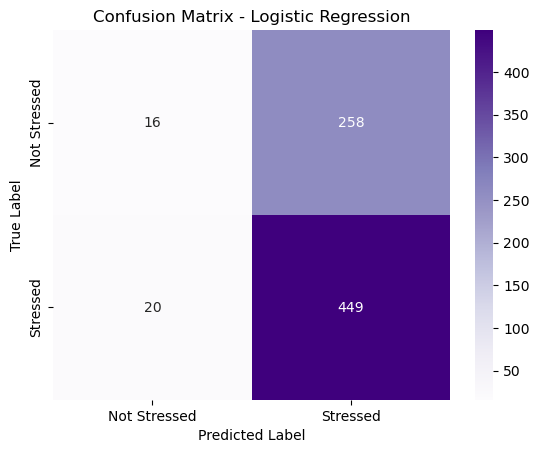

In [121]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Stressed', 'Stressed'], yticklabels=['Not Stressed', 'Stressed'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

#### Multinomial Naive Bayes

In [124]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Prediction
y_pred_nb = nb.predict(X_test)

# Evaluation
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\n Classification Report (Naive Bayes):\n")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.6339165545087483

 Classification Report (Naive Bayes):

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       274
           1       0.63      1.00      0.78       469

    accuracy                           0.63       743
   macro avg       0.82      0.50      0.39       743
weighted avg       0.77      0.63      0.49       743



#### Confusion Matrix for Naive Bayes

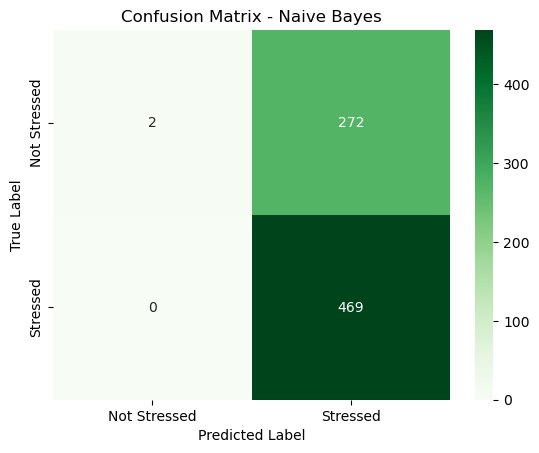

In [127]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Stressed', 'Stressed'], yticklabels=['Not Stressed', 'Stressed'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

### Insights and Conclusion